# Data preprocessing and cleaning

In dit notebook zullen we aan de slag gaan met data prepocessing. Hierbij zullen we een de opgeschoonde data van elke schilder van elke schilder als submap opslaan in een nieuwe map `cleaned_schilderijen`

Eerst zulle we beginnen met het controleren of alle afbeeldingen de extensie `.jpg` hebben

In [2]:
from pathlib import Path

raw_root = Path("schilderijen")

non_jpg_files = []

for painter_dir in raw_root.iterdir():
    if not painter_dir.is_dir():
        continue
    for f in painter_dir.iterdir():
        if f.suffix.lower() not in [".jpg", ".jpeg"]:
            non_jpg_files.append(f)

if not non_jpg_files:
    print("Alle afbeeldingen zijn JPG of JPEG – geen conversie nodig!")
else:
    print("Niet-JPG bestanden gevonden:")
    for f in non_jpg_files:
        print(" -", f)


Niet-JPG bestanden gevonden:
 - schilderijen\Mondriaan\tableay-no-iv-lozenge-composition.png
 - schilderijen\Picasso\picasso_meisje_met_duif.png
 - schilderijen\Rembrandt\kris.gif


We zien dat we 3 afbeeldingen hebben die niet de extensie `jpg` hebben. We zulle die afbeeldingen converteren

In [ ]:
from PIL import Image, UnidentifiedImageError
import os

# converteer niet-jpg naar jpg
for file in non_jpg_files:
    new_path = file.with_suffix(".jpg")
    try:
        with Image.open(file) as im:
            im = im.convert("RGB")
            im.save(new_path, "JPEG", quality=95)
            print("Converted:", file, "->", new_path)
    except Exception as e:
        print("Fout bij converteren:", file, e)

# verwijder oude PNG/GIF's
for file in non_jpg_files:
    if file.exists():
        os.remove(file)
        print("Removed original:", file)

Converted: schilderijen\Mondriaan\tableay-no-iv-lozenge-composition.png -> schilderijen\Mondriaan\tableay-no-iv-lozenge-composition.jpg
Converted: schilderijen\Picasso\picasso_meisje_met_duif.png -> schilderijen\Picasso\picasso_meisje_met_duif.jpg
Converted: schilderijen\Rembrandt\kris.gif -> schilderijen\Rembrandt\kris.jpg
Removed original: schilderijen\Mondriaan\tableay-no-iv-lozenge-composition.png
Removed original: schilderijen\Picasso\picasso_meisje_met_duif.png
Removed original: schilderijen\Rembrandt\kris.gif


Nu dat we alle afbeeldinge `jpg` zijn, zulle we controleren de kleurmodus controleren. Convolutionele neurale netwerken in Keras/TensorFlow verwachten standaard afbeeldingen met vorm `(hoogte, breedte, 3)` – dus **exact 3 kleurkanalen**. Daarom moeten alle afbeeldingen in de `RGB`-modus staan.

In [4]:
modes = set()
non_rgb_files = []

for painter_dir in raw_root.iterdir():
    if not painter_dir.is_dir():
        continue
    for f in painter_dir.iterdir():
        if f.suffix.lower() not in [".jpg", ".jpeg"]:
            continue
        try:
            with Image.open(f) as im:
                modes.add(im.mode)
                if im.mode != "RGB":
                    non_rgb_files.append((f, im.mode))
        except UnidentifiedImageError:
            print("Corrupt bestand:", f)

print("\nAangetroffen modes:", modes)
print("Aantal niet-RGB bestanden:", len(non_rgb_files))
for f, m in non_rgb_files[:10]:  # toon max 10 voorbeelden
    print(" -", f, "mode:", m)



Aangetroffen modes: {'RGB', 'P', 'CMYK', 'L'}
Aantal niet-RGB bestanden: 9
 - schilderijen\Picasso\bust-of-woman-with-yellow-ribbon-jacqueline-1962.jpg mode: P
 - schilderijen\Picasso\dream-and-lie-of-franco-1937.jpg mode: L
 - schilderijen\Picasso\large.jpg mode: CMYK
 - schilderijen\Picasso\portrait-of-child-1951.jpg mode: L
 - schilderijen\Picasso\the-eight-names-of-picasso-1970.jpg mode: L
 - schilderijen\Picasso\the-girls-of-avignon-study-1907.jpg mode: L
 - schilderijen\Picasso\untitled-1966.jpg mode: L
 - schilderijen\Picasso\untitled-1970.jpg mode: L
 - schilderijen\Picasso\woman-with-hat-1962-1.jpg mode: P


Gelukkig hebben we hier dus weer een controle gedaan in verband met de geldigheid van de afbeeldingen, want zoals we zien hebben 9 afbeeldingen die geen `RGB-modus` hebben. Die afbeeldingen zullen we dus moeten "forceren" naar `RGB`

In [5]:
for f, m in non_rgb_files:
    try:
        with Image.open(f) as im:
            im = im.convert("RGB")
            im.save(f, "JPEG", quality=95)
            print("Fixed color mode:", f, f"(was {m})")
    except Exception as e:
        print("Fout bij RGB-conversie:", f, e)

Fixed color mode: schilderijen\Picasso\bust-of-woman-with-yellow-ribbon-jacqueline-1962.jpg (was P)
Fixed color mode: schilderijen\Picasso\dream-and-lie-of-franco-1937.jpg (was L)
Fixed color mode: schilderijen\Picasso\large.jpg (was CMYK)
Fixed color mode: schilderijen\Picasso\portrait-of-child-1951.jpg (was L)
Fixed color mode: schilderijen\Picasso\the-eight-names-of-picasso-1970.jpg (was L)
Fixed color mode: schilderijen\Picasso\the-girls-of-avignon-study-1907.jpg (was L)
Fixed color mode: schilderijen\Picasso\untitled-1966.jpg (was L)
Fixed color mode: schilderijen\Picasso\untitled-1970.jpg (was L)
Fixed color mode: schilderijen\Picasso\woman-with-hat-1962-1.jpg (was P)


### Waarom kiezen we `quality=95` bij het opslaan van JPEG-afbeeldingen?

Wanneer we een afbeelding als JPEG opslaan, wordt er altijd **compressie** toegepast. Dat betekent dat er tijdens het opslaan **informatie uit het beeld verloren gaat** om het bestand kleiner te maken. De parameter `quality=` bepaalt hoe sterk die compressie is: hoe hoger de waarde, hoe minder kwaliteitsverlies.

We gebruiken **`quality=95`** omdat dit in de praktijk de **beste balans** biedt tussen kwaliteit en bestandsgrootte.
Bij deze waarde blijft de visuele kwaliteit **nagenoeg identiek** aan het origineel, terwijl de bestanden **aanzienlijk kleiner** zijn dan wanneer je `quality=100` gebruikt. Voor machine learning is dit ideaal: het model behoudt alle belangrijke visuele kenmerken (vormen, texturen, kleuren), maar we verspillen geen onnodige opslagruimte of laadtijd.

We zullen onze geconverteerde afbeeldingen even visualiseren

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import math

def show_in_rows(files, max_per_row=3, figsize=(12,4)):
    total = len(files)
    rows = math.ceil(total / max_per_row)

    idx = 0
    for r in range(rows):
        subset = files[idx:idx + max_per_row]
        idx += max_per_row
        
        plt.figure(figsize=figsize)
        for i, f in enumerate(subset):
            img = Image.open(f)
            plt.subplot(1, len(subset), i+1)
            plt.imshow(img)
            plt.title(Path(f).name)
            plt.axis("off")
        plt.show()

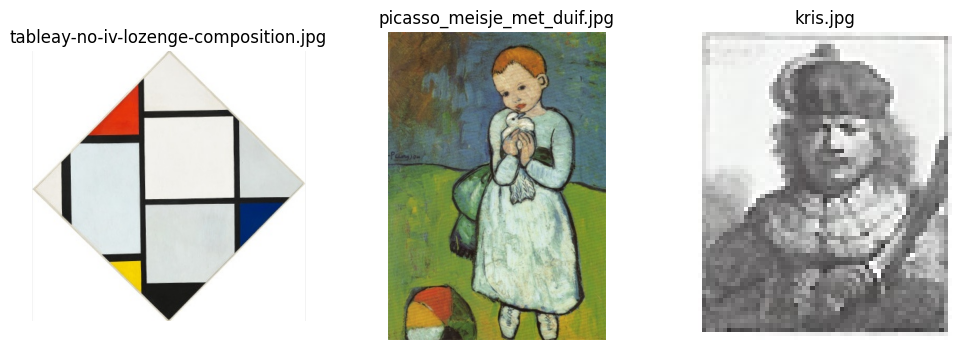

In [15]:
# 3 geconverteerde afbeeldingen
converted_files = [
    Path("schilderijen/Mondriaan/tableay-no-iv-lozenge-composition.jpg"),
    Path("schilderijen/Picasso/picasso_meisje_met_duif.jpg"),
    Path("schilderijen/Rembrandt/kris.jpg"),
]

show_in_rows(converted_files, max_per_row=3)

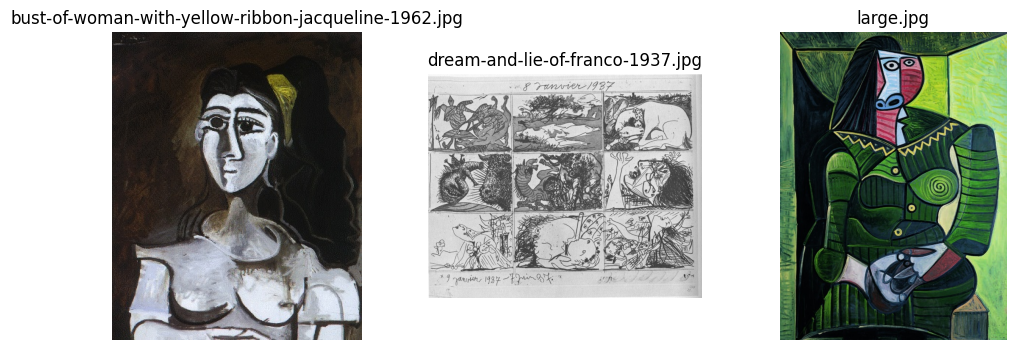

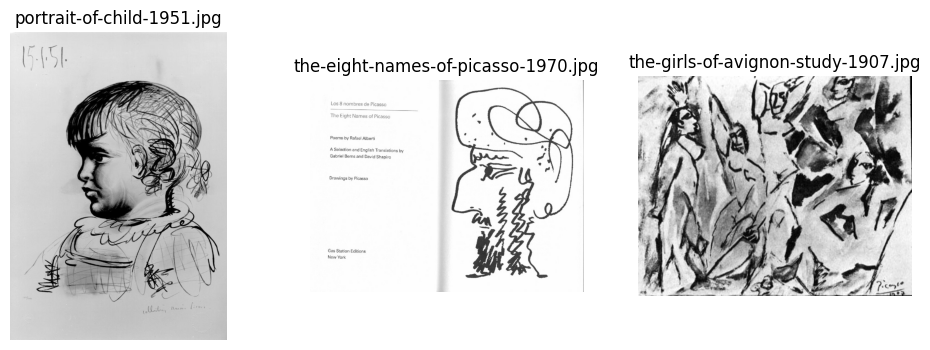

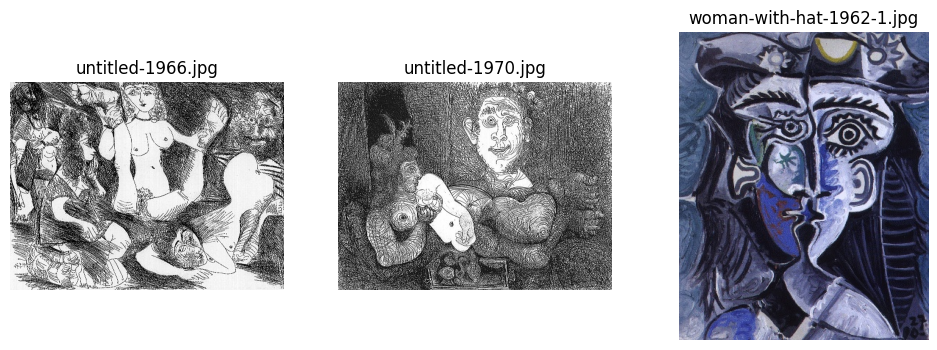

In [16]:
# forced RGB bestanden
forced_files = [f for f, mode in non_rgb_files]
show_in_rows(forced_files, max_per_row=3)